<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/main/TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jupyter Setup

In [2]:
!git clone -b main https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

fatal: destination path 'DATCapstone' already exists and is not an empty directory.
/content/DATCapstone/data


In [3]:
# Installs
!pip install pytorch-lightning
!pip install pytorch-forecasting

In [4]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, QuantileLoss
import os
import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile
from pytorch_forecasting.data.encoders import NaNLabelEncoder

# Data Preparation

In [5]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [6]:
# Cleaning
emb_cols = [col for col in df.columns if col.startswith('emb_')]
target_cols = [col for col in df.columns if 'Target' in col]
non_target_cols = [col for col in df.columns if col not in target_cols + ['Date', 'Ticker']]

df.loc[:, emb_cols] = df[emb_cols].fillna(0)
df.loc[:, non_target_cols] = df[non_target_cols].fillna(0)
df = df.dropna(subset=target_cols)


# Model Setup

In [231]:
# Companies
print(df['Ticker'].unique())
# Targets
print(target_cols)

['AAPL' 'AMD' 'AMZN' 'AVGO' 'GOOGL' 'META' 'MSFT' 'NVDA' 'ORCL' 'TSLA']
['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']


In [535]:
# These were the best parameters that led to the best performance
target_to_encoder = {
    "Target_1day": 5,
    "Target_1week": 20,
    "Target_1month": 100,
    "Target_1year": 200
}

In [536]:
# Set parameters
ticker = "MSFT"            # Companies, can change
target = "Target_1month"    # Targets, can change
max_encoder_length = target_to_encoder[target]    # Lookback period
max_prediction_length = 1
batch_size = 32
max_epochs = 50

In [537]:
print(max_encoder_length)

100


In [538]:
# Filter data for the specific ticker
df_ticker = df[df['Ticker'] == ticker].copy()
df_ticker = df_ticker.sort_values(by='Date')
df_ticker[target] = df_ticker[target].fillna(0)
df_ticker[target] = df_ticker[target].replace([np.inf, -np.inf], 0)

# Create time index
df_ticker = df_ticker.reset_index(drop=True)
df_ticker['time_idx'] = df_ticker.index

# Get feature columns
feature_cols = [col for col in df_ticker.columns if 'Target' not in col
               and col not in ['Date', 'Ticker', 'time_idx']
               and not col.startswith('emb_')]

# Fill missing values
df_ticker[feature_cols] = df_ticker[feature_cols].fillna(0)

# Check if there's enough data
if len(df_ticker) <= max_encoder_length + max_prediction_length + 1:
    print(f"[{ticker}] {target}: Not enough data. Skipping.")
else:
    print(f"Data for {ticker} ready with {len(df_ticker)} rows and {len(feature_cols)} features.")

Data for MSFT ready with 652 rows and 43 features.


# Model Architecture

In [539]:
# Normalizer parameters
target_normalizer=GroupNormalizer(
    method="robust",  # Robust to outliers
    center=True,
    transformation= "softplus",  # Handle negative values
)
# Check for outliers
print(f"Target min: {df_ticker[target].min()}, max: {df_ticker[target].max()}")

Target min: -52.49069213867188, max: 49.731781005859375


In [540]:
# Create trainer with early stopping
early_stop = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=10,
    verbose=True,
    mode="min"
)

In [541]:
# Calculate cutoff points for train/val/test splits
train_cutoff = df_ticker.shape[0] - int(df_ticker.shape[0] * 0.3)  # 70% for training
val_cutoff = df_ticker.shape[0] - int(df_ticker.shape[0] * 0.15)   # 15% for validation, 15% for testing

print(f"Training cutoff at index {train_cutoff} (70% of {df_ticker.shape[0]} rows)")
print(f"Validation cutoff at index {val_cutoff} (85% of {df_ticker.shape[0]} rows)")

Training cutoff at index 457 (70% of 652 rows)
Validation cutoff at index 555 (85% of 652 rows)


In [542]:
# Create TimeSeriesDataSet for training
training = TimeSeriesDataSet(
    data=df_ticker[lambda x: x.time_idx <= train_cutoff],
    time_idx="time_idx",
    target=target,
    group_ids=["Ticker"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Ticker"],
    time_varying_known_reals=feature_cols,
    time_varying_unknown_reals=[target],
    target_normalizer=GroupNormalizer(
        groups=["Ticker"],
    ),
    categorical_encoders={
        "Ticker": NaNLabelEncoder(add_nan=True)
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True
)

# Validation set - from train_cutoff+1 to val_cutoff
validation = TimeSeriesDataSet.from_dataset(
    training,
    df_ticker,
    #min_prediction_idx=train_cutoff + 1,
    #max_prediction_idx=val_cutoff
)

# Test set - from val_cutoff+1 to end
test = TimeSeriesDataSet.from_dataset(
    training,
    df_ticker,
    min_prediction_idx=val_cutoff + 1
)


In [543]:
# Dataloaders
train_dataloader = training.to_dataloader(
    batch_size=batch_size,
    shuffle=True,
    num_workers=7
)

val_dataloader = validation.to_dataloader(
    batch_size=batch_size,
    shuffle=False,
    num_workers=7
)

test_dataloader = test.to_dataloader(
    batch_size=batch_size,
    shuffle=False,
    num_workers=7
)

print(f"Training samples: {len(training)}")
print(f"Validation samples: {len(validation)}")
print(f"Test samples: {len(test)}")


Training samples: 358
Validation samples: 552
Test samples: 96


In [544]:
# Initialize  TFT model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,          # change based on how much training and time
    hidden_size=64,
    attention_head_size=2,
    dropout=0.3,
    hidden_continuous_size=32,
    lstm_layers=2,
    output_size=7,
    loss=QuantileLoss(),
    reduce_on_plateau_patience=5,
    optimizer="adamw",
    weight_decay=1e-2,
    reduce_on_plateau_reduction=2.0,
)

In [545]:
trainer = pl.Trainer(
    max_epochs=max_epochs,  # Increase epochs but let early stopping decide
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=[early_stop],
    gradient_clip_val=0.1,  # Prevent exploding gradients
    accelerator="gpu",
    devices="auto",
)

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


# Model Running

In [546]:
print(f"Starting training for {max_epochs} epochs...")
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
print("Training complete")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 2      | train
3  | prescalers                         | ModuleDict                      | 3.0 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 13.9 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 376 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 366 K  | train
7  | static_context_variable_selectio

Starting training for 50 epochs...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 8.665
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 8.665


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.388 >= min_delta = 0.01. New best score: 8.277
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.388 >= min_delta = 0.01. New best score: 8.277


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.535 >= min_delta = 0.01. New best score: 7.742
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.535 >= min_delta = 0.01. New best score: 7.742


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.187 >= min_delta = 0.01. New best score: 6.556
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.187 >= min_delta = 0.01. New best score: 6.556


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.585 >= min_delta = 0.01. New best score: 5.971
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.585 >= min_delta = 0.01. New best score: 5.971


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.015 >= min_delta = 0.01. New best score: 5.956
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.01. New best score: 5.956


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.073 >= min_delta = 0.01. New best score: 4.883
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.073 >= min_delta = 0.01. New best score: 4.883


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.438 >= min_delta = 0.01. New best score: 4.445
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.438 >= min_delta = 0.01. New best score: 4.445


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.515 >= min_delta = 0.01. New best score: 3.930
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.515 >= min_delta = 0.01. New best score: 3.930


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.143 >= min_delta = 0.01. New best score: 3.787
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.143 >= min_delta = 0.01. New best score: 3.787


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.357 >= min_delta = 0.01. New best score: 3.431
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.357 >= min_delta = 0.01. New best score: 3.431


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.138 >= min_delta = 0.01. New best score: 3.292
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.138 >= min_delta = 0.01. New best score: 3.292


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.053 >= min_delta = 0.01. New best score: 3.239
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.053 >= min_delta = 0.01. New best score: 3.239


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.059 >= min_delta = 0.01. New best score: 3.180
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.059 >= min_delta = 0.01. New best score: 3.180


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.089 >= min_delta = 0.01. New best score: 3.091
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.089 >= min_delta = 0.01. New best score: 3.091


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.033 >= min_delta = 0.01. New best score: 3.058
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.01. New best score: 3.058


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.076 >= min_delta = 0.01. New best score: 2.982
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.076 >= min_delta = 0.01. New best score: 2.982


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.052 >= min_delta = 0.01. New best score: 2.929
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.052 >= min_delta = 0.01. New best score: 2.929


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 10 records. Best score: 2.929. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 2.929. Signaling Trainer to stop.


Training complete


# Results

In [547]:
# Evaluate on validation set
val_predictions = tft.predict(val_dataloader)
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_pred = val_predictions.cpu().detach().numpy()
val_true = val_actuals.cpu().detach().numpy()

# Evaluate on test set - this is your true performance measure
test_predictions = tft.predict(test_dataloader)
test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
test_pred = test_predictions.cpu().detach().numpy()
test_true = test_actuals.cpu().detach().numpy()

# Make sure arrays have the same length
val_min_length = min(len(val_true), len(val_pred))
test_min_length = min(len(test_true), len(test_pred))


INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.ran

In [548]:
# Calculate metrics
print(f"\n[{ticker}] Target: {target}")
print("Validation Metrics:")
val_mae = mean_absolute_error(val_true[:val_min_length], val_pred[:val_min_length])
val_rmse = np.sqrt(mean_squared_error(val_true[:val_min_length], val_pred[:val_min_length]))
val_r2 = r2_score(val_true[:val_min_length], val_pred[:val_min_length])
print(f"MAE : {val_mae:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"R2  : {val_r2:.4f}")

print("\nTest Metrics:")
test_mae = mean_absolute_error(test_true[:test_min_length], test_pred[:test_min_length])
test_rmse = np.sqrt(mean_squared_error(test_true[:test_min_length], test_pred[:test_min_length]))
test_r2 = r2_score(test_true[:test_min_length], test_pred[:test_min_length])
print(f"MAE : {test_mae:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"R2  : {test_r2:.4f}")


[MSFT] Target: Target_1month
Validation Metrics:
MAE : 5.6994
RMSE: 7.3627
R2  : 0.8661

Test Metrics:
MAE : 6.8286
RMSE: 8.6610
R2  : 0.6961


# Visualization

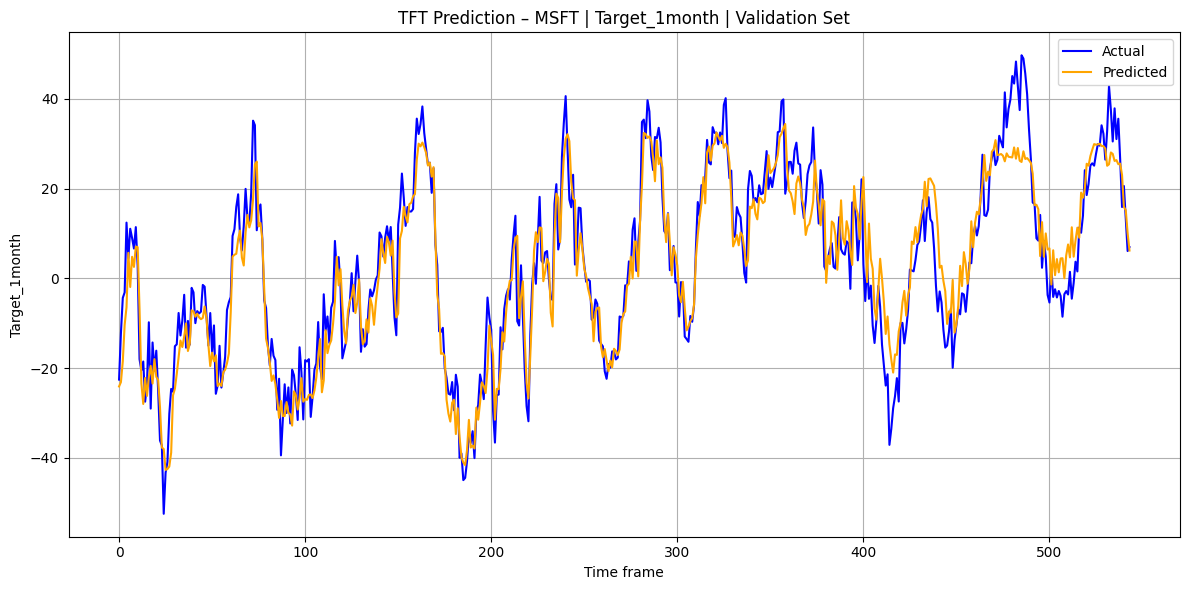

In [549]:
# Validation set visualization
plt.figure(figsize=(12, 6))
plt.plot(val_true[:val_min_length], label='Actual', color='blue')
plt.plot(val_pred[:val_min_length], label='Predicted', color='orange')
plt.title(f"TFT Prediction – {ticker} | {target} | Validation Set")
plt.xlabel('Time frame')
plt.ylabel(target)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


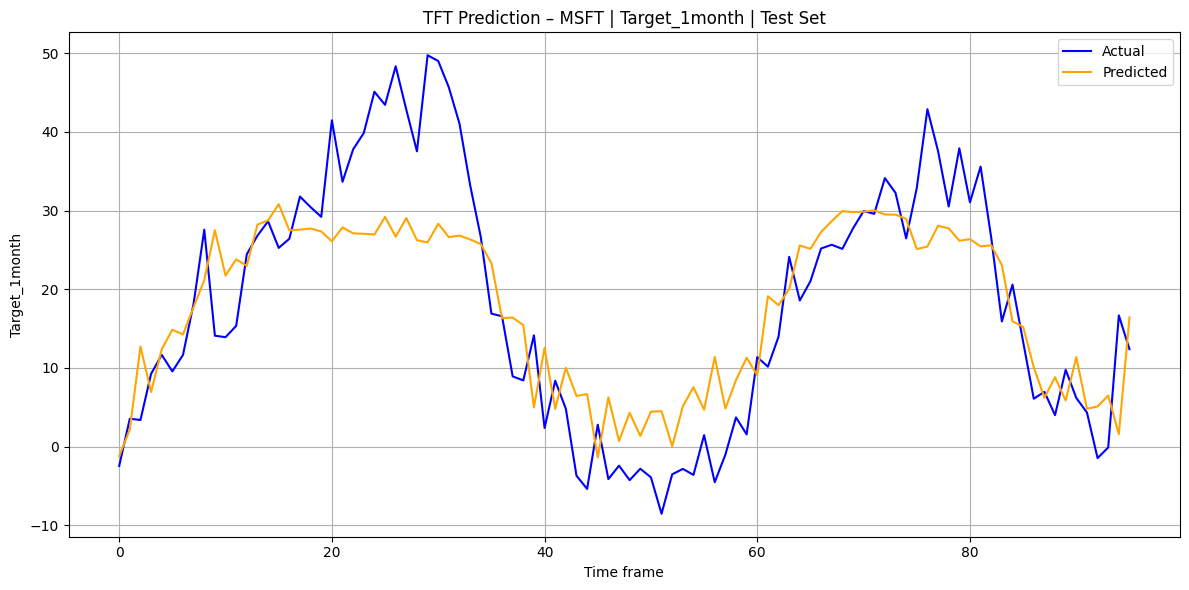

In [550]:
# Test set visualization
plt.figure(figsize=(12, 6))
plt.plot(test_true[:test_min_length], label='Actual', color='blue')
plt.plot(test_pred[:test_min_length], label='Predicted', color='orange')
plt.title(f"TFT Prediction – {ticker} | {target} | Test Set")
plt.xlabel('Time frame')
plt.ylabel(target)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [551]:
# Save the plot
filename = f'msft_tft_{target}.png'
plt.savefig(filename)
plt.show()

<Figure size 640x480 with 0 Axes>